# TP Machine Learning - Industrie Sidérurgique
## Partie 2 : Prédiction de la consommation énergétique

Dans cette partie, nous allons développer des modèles de machine learning pour prédire la consommation énergétique
d'une industrie sidérurgique. Cette capacité de prédiction est cruciale pour l'optimisation des coûts et la
planification de la production.

### Objectifs :
- Implémenter différents modèles de régression
- Comparer leurs performances
- Interpréter les résultats dans un contexte industriel

### Structure des données :

1. **Variable cible (à prédire)** :
   - `Usage_kWh` : Consommation d'énergie en kilowattheures

2. **Variables descriptives numériques** :
   - `Lagging_Current_Reactive.Power_kVarh` : Puissance réactive en retard
   - `Leading_Current_Reactive_Power_kVarh` : Puissance réactive en avance
   - `CO2(tCO2)` : Émissions de CO2
   - `Lagging_Current_Power_Factor` : Facteur de puissance en retard
   - `Leading_Current_Power_Factor` : Facteur de puissance en avance
   - `NSM` : Number of Seconds from Midnight (temps)

3. **Variables catégorielles** :
   - `Day_of_week` : Jour de la semaine (Monday à Sunday)
   - `WeekStatus` : Type de jour (Weekday/Weekend)

### Prétraitement appliqué :
1. Standardisation des variables numériques (moyenne=0, écart-type=1)
2. Encodage one-hot des variables catégorielles
3. Division train/test (80%/20%)

### Modèles abordés :
- Régression linéaire (baseline)
- K plus proches voisins (KNN)
- Arbres de décision
- Random Forest
- Réseaux de neurones

In [1]:
# Import des packages nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                           explained_variance_score, max_error)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy import stats
import os

# Configuration de l'affichage
sns.set_theme()  # Utilisation du style seaborn directement
plt.rcParams['figure.figsize'] = [10, 6]

Fichier de données déjà présent.
Données chargées avec succès : 35040 observations, 11 variables
Dimensions du dataset :
Nombre d'observations : 35,040
Nombre de variables : 11

Résumé statistique des variables numériques :


,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Usage_kWh
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000,27.386892
std,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317,33.444380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000,3.200000
50%,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000,4.570000
75%,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000,51.237500
max,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000,157.180000


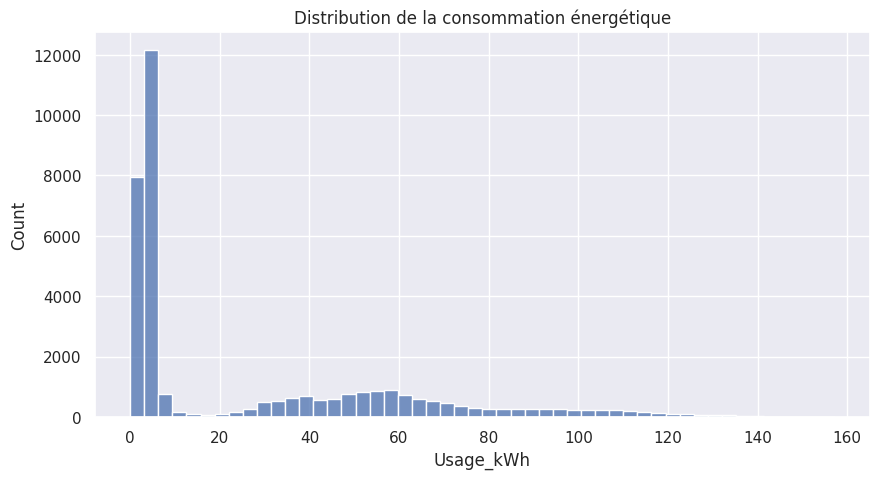

In [3]:
# Téléchargement et préparation des données
if not os.path.exists('Steel_industry_data.csv'):
    print("Téléchargement des données...")
    # Télécharger le fichier zip
    !wget -O steel_industry_data.zip https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip
    # Décompresser le fichier
    !unzip -o steel_industry_data.zip
    print("Données téléchargées et décompressées.")
else:
    print("Fichier de données déjà présent.")

# Chargement des données
try:
    df = pd.read_csv('Steel_industry_data.csv')
    print(f"Données chargées avec succès : {df.shape[0]} observations, {df.shape[1]} variables")
except Exception as e:
    print(f"Erreur lors du chargement des données : {e}")
    raise

# Séparation des variables
target = 'Usage_kWh'
numeric_features = [
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'CO2(tCO2)',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM'
]
categorical_features = ['Day_of_week', 'WeekStatus', 'period']

# Affichage des dimensions
print("Dimensions du dataset :")
print(f"Nombre d'observations : {df.shape[0]:,}")
print(f"Nombre de variables : {df.shape[1]:,}")

# Résumé statistique des variables numériques
print("\nRésumé statistique des variables numériques :")
display(df[numeric_features + [target]].describe())

# Distribution de la variable cible
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x=target, bins=50)
# /!\ Complétez les '...' pour afficher comme titre de la figure (Matplotlib): Distribution de la consommation énergétique /!\
plt.title("Distribution de la consommation énergétique")
plt.show()

### 1. Analyse temporelle et création des caractéristiques

Nous allons structurer nos données temporelles en plusieurs niveaux :
1. Jours de la semaine (lundi à dimanche)
2. Type de jour (semaine/weekend)
3. Périodes de la journée (6 blocs de 4h)

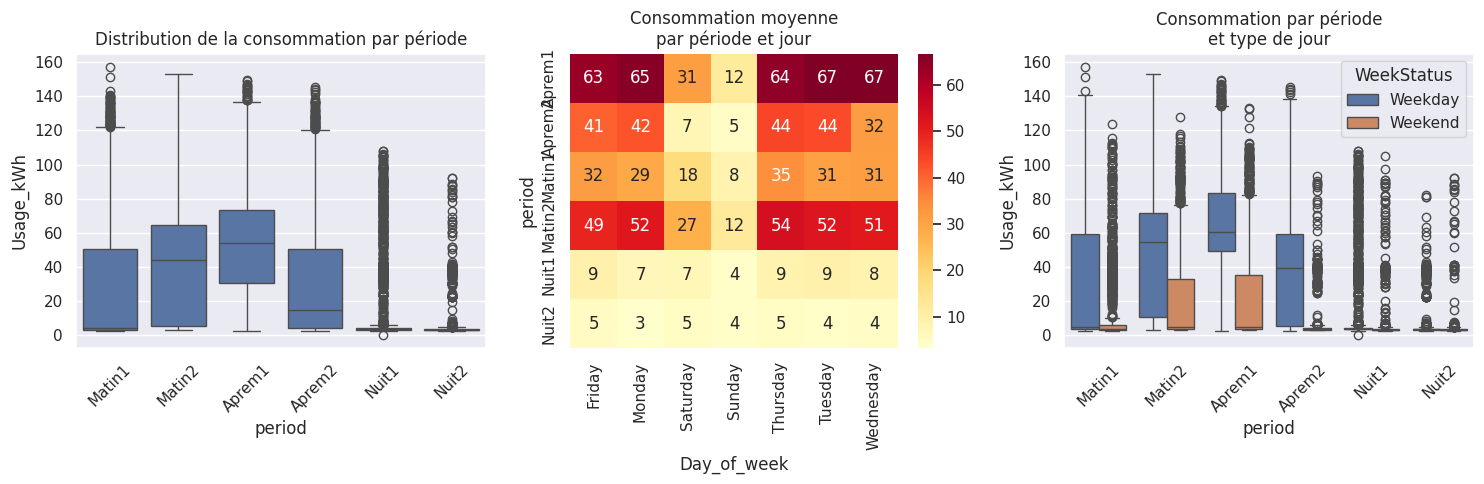


Consommation moyenne (kWh) par période et type de jour :


mean                                                       std  \
WeekStatus  Weekday                                    Weekend        Weekday   
Day_of_week  Friday Monday Thursday Tuesday Wednesday Saturday Sunday  Friday   
period                                                                          
Aprem1        63.24  65.48    64.34   66.51     66.71    31.37  12.09   29.33   
Aprem2        40.65  42.36    44.20   43.58     31.54     7.19   4.61   31.64   
Matin1        31.65  29.23    34.66   30.63     31.39    17.64   8.46   35.80   
Matin2        49.32  51.76    54.18   52.30     50.98    27.28  12.30   33.18   
Nuit1          9.26   6.83     8.56    9.39      8.44     7.12   3.98   18.16   
Nuit2          5.06   3.21     4.72    4.16      4.47     4.91   3.84    8.49   

                                                               
WeekStatus                                     Weekend         
Day_of_week Monday Thursday Tuesday Wednesday Saturday Sunday  
period                                                         
Aprem1       27.59    27.58   28.27     31.70    29.88  18.43  
Aprem2       32.51    31.41   32.43     31.46    13.25   5.86  
Matin1       34.52    39.79   35.15     35.54    24.14  16.71  
Matin2       35.09    37.06   36.10     35.18    27.15  20.64  
Nuit1        14.01    16.88   17.48     15.88    14.87   5.37  
Nuit2         0.53     6.49    4.74      5.32    10.22   4.67

In [4]:
# Création des périodes de la journée industrielle
def create_industrial_periods(df):
    # Conversion NSM en heures
    df['hour'] = df['NSM'] / 3600

    # Création des périodes avec la journée commençant à 6h
    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 10),   # Matin1
        (df['hour'] >= 10) & (df['hour'] < 14),  # Matin2
        (df['hour'] >= 14) & (df['hour'] < 18),  # Aprem1
        (df['hour'] >= 18) & (df['hour'] < 22),  # Aprem2
        (df['hour'] >= 22) | (df['hour'] < 2),   # Nuit1
        (df['hour'] >= 2) & (df['hour'] < 6)     # Nuit2
    ]

    periods = ['Matin1', 'Matin2', 'Aprem1', 'Aprem2', 'Nuit1', 'Nuit2']
    df['period'] = np.select(conditions, periods, default='Nuit2')

    return df

# Application des périodes
# /!\ Complétez les '...' pour transformer df grâce à la fonction create_industrial_periods() /!\

df = create_industrial_periods(df)


# Visualisation des patterns de consommation
plt.figure(figsize=(15, 5))

# 1. Consommation moyenne par période
plt.subplot(1, 3, 1)
period_order = ['Matin1', 'Matin2', 'Aprem1', 'Aprem2', 'Nuit1', 'Nuit2']
sns.boxplot(data=df, x='period', y='Usage_kWh', order=period_order)
plt.title('Distribution de la consommation par période')
plt.xticks(rotation=45)

# 2. Heatmap période x jour
pivot_period_day = pd.pivot_table(df,
                                values='Usage_kWh',
                                index='period',
                                columns='Day_of_week',
                                aggfunc='mean')
plt.subplot(1, 3, 2)
sns.heatmap(pivot_period_day, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Consommation moyenne\npar période et jour')

# 3. Comparaison semaine/weekend
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='period', y='Usage_kWh', hue='WeekStatus', order=period_order)
plt.title('Consommation par période\net type de jour')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Statistiques détaillées
print("\nConsommation moyenne (kWh) par période et type de jour :")
pivot_stats = pd.pivot_table(df,
                           values='Usage_kWh',
                           index='period',
                           columns=['WeekStatus', 'Day_of_week'],
                           aggfunc=['mean', 'std'])
display(pivot_stats.round(2))

❓ **Questions sur les patterns temporels :**

1. **Cycles de production**
   - Quelle période montre la plus forte consommation ? Pourquoi ?
   - Comment évolue la consommation entre Matin1 et Matin2 ?

2. **Variations jour/nuit**
   - Quelle est la différence de consommation entre périodes diurnes et nocturnes ?
   - La variabilité est-elle plus importante le jour ou la nuit ?

3. **Impact weekend**
   - Comment le pattern de consommation change-t-il le weekend ?
   - Quelles périodes montrent la plus grande différence semaine/weekend ?
   - Quelles recommandations pour l'optimisation énergétique ?

In [5]:
# Préparation des données

# 1. Standardisation des variables numériques
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[numeric_features]),
    columns=numeric_features
)

# 2. Encodage des variables catégorielles
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(df[categorical_features])

# Noms des colonnes encodées
day_names = [f'Day_{day}' for day in encoder.categories_[0]]
week_status_names = [f'Status_{status}' for status in encoder.categories_[1]]
period_names = [f'Period_{period}' for period in encoder.categories_[2]]
encoded_columns = day_names + week_status_names + period_names

# Vérification des dimensions
print("\nDimensions de l'encodage :")
print(f"Nombre de colonnes encodées : {len(encoded_columns)}")
print(f"Shape des données encodées : {categorical_encoded.shape}")
print("Catégories encodées :")
for i, feature in enumerate(categorical_features):
    print(f"{feature}: {list(encoder.categories_[i])}")

# Création du DataFrame avec les variables encodées
df_encoded = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# 3. Combinaison des features
X = pd.concat([df_scaled, df_encoded], axis=1)
# /!\ Complétez les '...' pour affecter la variable y à la colonne target du dataframe /!\
y = df[target]

print("Structure des données préparées :")
print(f"Variables numériques standardisées : {len(numeric_features)}")
print(f"Variables catégorielles encodées : {len(encoded_columns)}")
print(f"Dimensions finales de X : {X.shape}")

# 4. Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nDimensions des ensembles d'entraînement et de test :")
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")


Dimensions de l'encodage :
Nombre de colonnes encodées : 15
Shape des données encodées : (35040, 15)
Catégories encodées :
Day_of_week: ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
WeekStatus: ['Weekday', 'Weekend']
period: ['Aprem1', 'Aprem2', 'Matin1', 'Matin2', 'Nuit1', 'Nuit2']
Structure des données préparées :
Variables numériques standardisées : 6
Variables catégorielles encodées : 15
Dimensions finales de X : (35040, 21)

Dimensions des ensembles d'entraînement et de test :
X_train : (28032, 21)
X_test : (7008, 21)
y_train : (28032,)
y_test : (7008,)


### 2. Régression linéaire

Pour comprendre comment la régression linéaire trouve ses coefficients, implémentons notre propre version :

y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ

La loss (erreur quadratique moyenne) est :
L = (1/n) Σ(y_pred - y_true)²

Les coefficients sont mis à jour selon :
β_new = β_old - α * ∂L/∂β
où α est le taux d'apprentissage

Iteration 1000/15000, Loss: 27.4440
Iteration 2000/15000, Loss: 24.2076
Iteration 3000/15000, Loss: 23.3008
Iteration 4000/15000, Loss: 23.0235
Iteration 5000/15000, Loss: 22.9324
Iteration 6000/15000, Loss: 22.9003
Iteration 7000/15000, Loss: 22.8884
Iteration 8000/15000, Loss: 22.8838
Iteration 9000/15000, Loss: 22.8819
Iteration 10000/15000, Loss: 22.8811
Iteration 11000/15000, Loss: 22.8808
Iteration 12000/15000, Loss: 22.8807
Iteration 13000/15000, Loss: 22.8806
Iteration 14000/15000, Loss: 22.8806
Iteration 15000/15000, Loss: 22.8806

Comparaison des deux implémentations :

Métriques de performance :


,GD,Sklearn
R² score,0.9843,0.9843
MSE,17.8908,17.8882
RMSE,4.2298,4.2294



Comparaison des coefficients :


,Feature,GD,Sklearn,Différence
0,Lagging_Current_Reactive.Power_kVarh,5.4098,5.4052,0.0045
1,Leading_Current_Reactive_Power_kVarh,0.9523,0.9484,0.0039
2,CO2(tCO2),26.4665,26.4731,0.0065
3,Lagging_Current_Power_Factor,2.2914,2.2904,0.0011
4,Leading_Current_Power_Factor,2.4144,2.4083,0.0060
5,NSM,0.0710,0.0721,0.0010
6,Day_Friday,1.5277,-0.1311,1.6588
7,Day_Monday,1.5366,-0.1224,1.6589
8,Day_Saturday,3.2727,-0.0450,3.3177
9,Day_Sunday,3.2847,-0.0337,3.3184



Équation de régression :
Usage_kWh = 14.93 + (26.47 × CO2(tCO2)) + (8.37 × Status_Weekday) + (6.56 × Status_Weekend) + (5.41 × Lagging_Current_Reactive.Power_kVarh) + (3.75 × Period_Aprem1) + (3.28 × Day_Sunday) + (3.27 × Day_Saturday) + (3.06 × Period_Aprem2) + (2.75 × Period_Matin2) + (2.41 × Leading_Current_Power_Factor) + (2.29 × Lagging_Current_Power_Factor) + (2.24 × Day_Tuesday) + (1.96 × Period_Nuit2) + (1.83 × Period_Nuit1) + (1.61 × Day_Wednesday) + (1.58 × Period_Matin1) + (1.54 × Day_Monday) + (1.53 × Day_Friday) + (1.46 × Day_Thursday) + (0.95 × Leading_Current_Reactive_Power_kVarh) + (0.07 × NSM) 



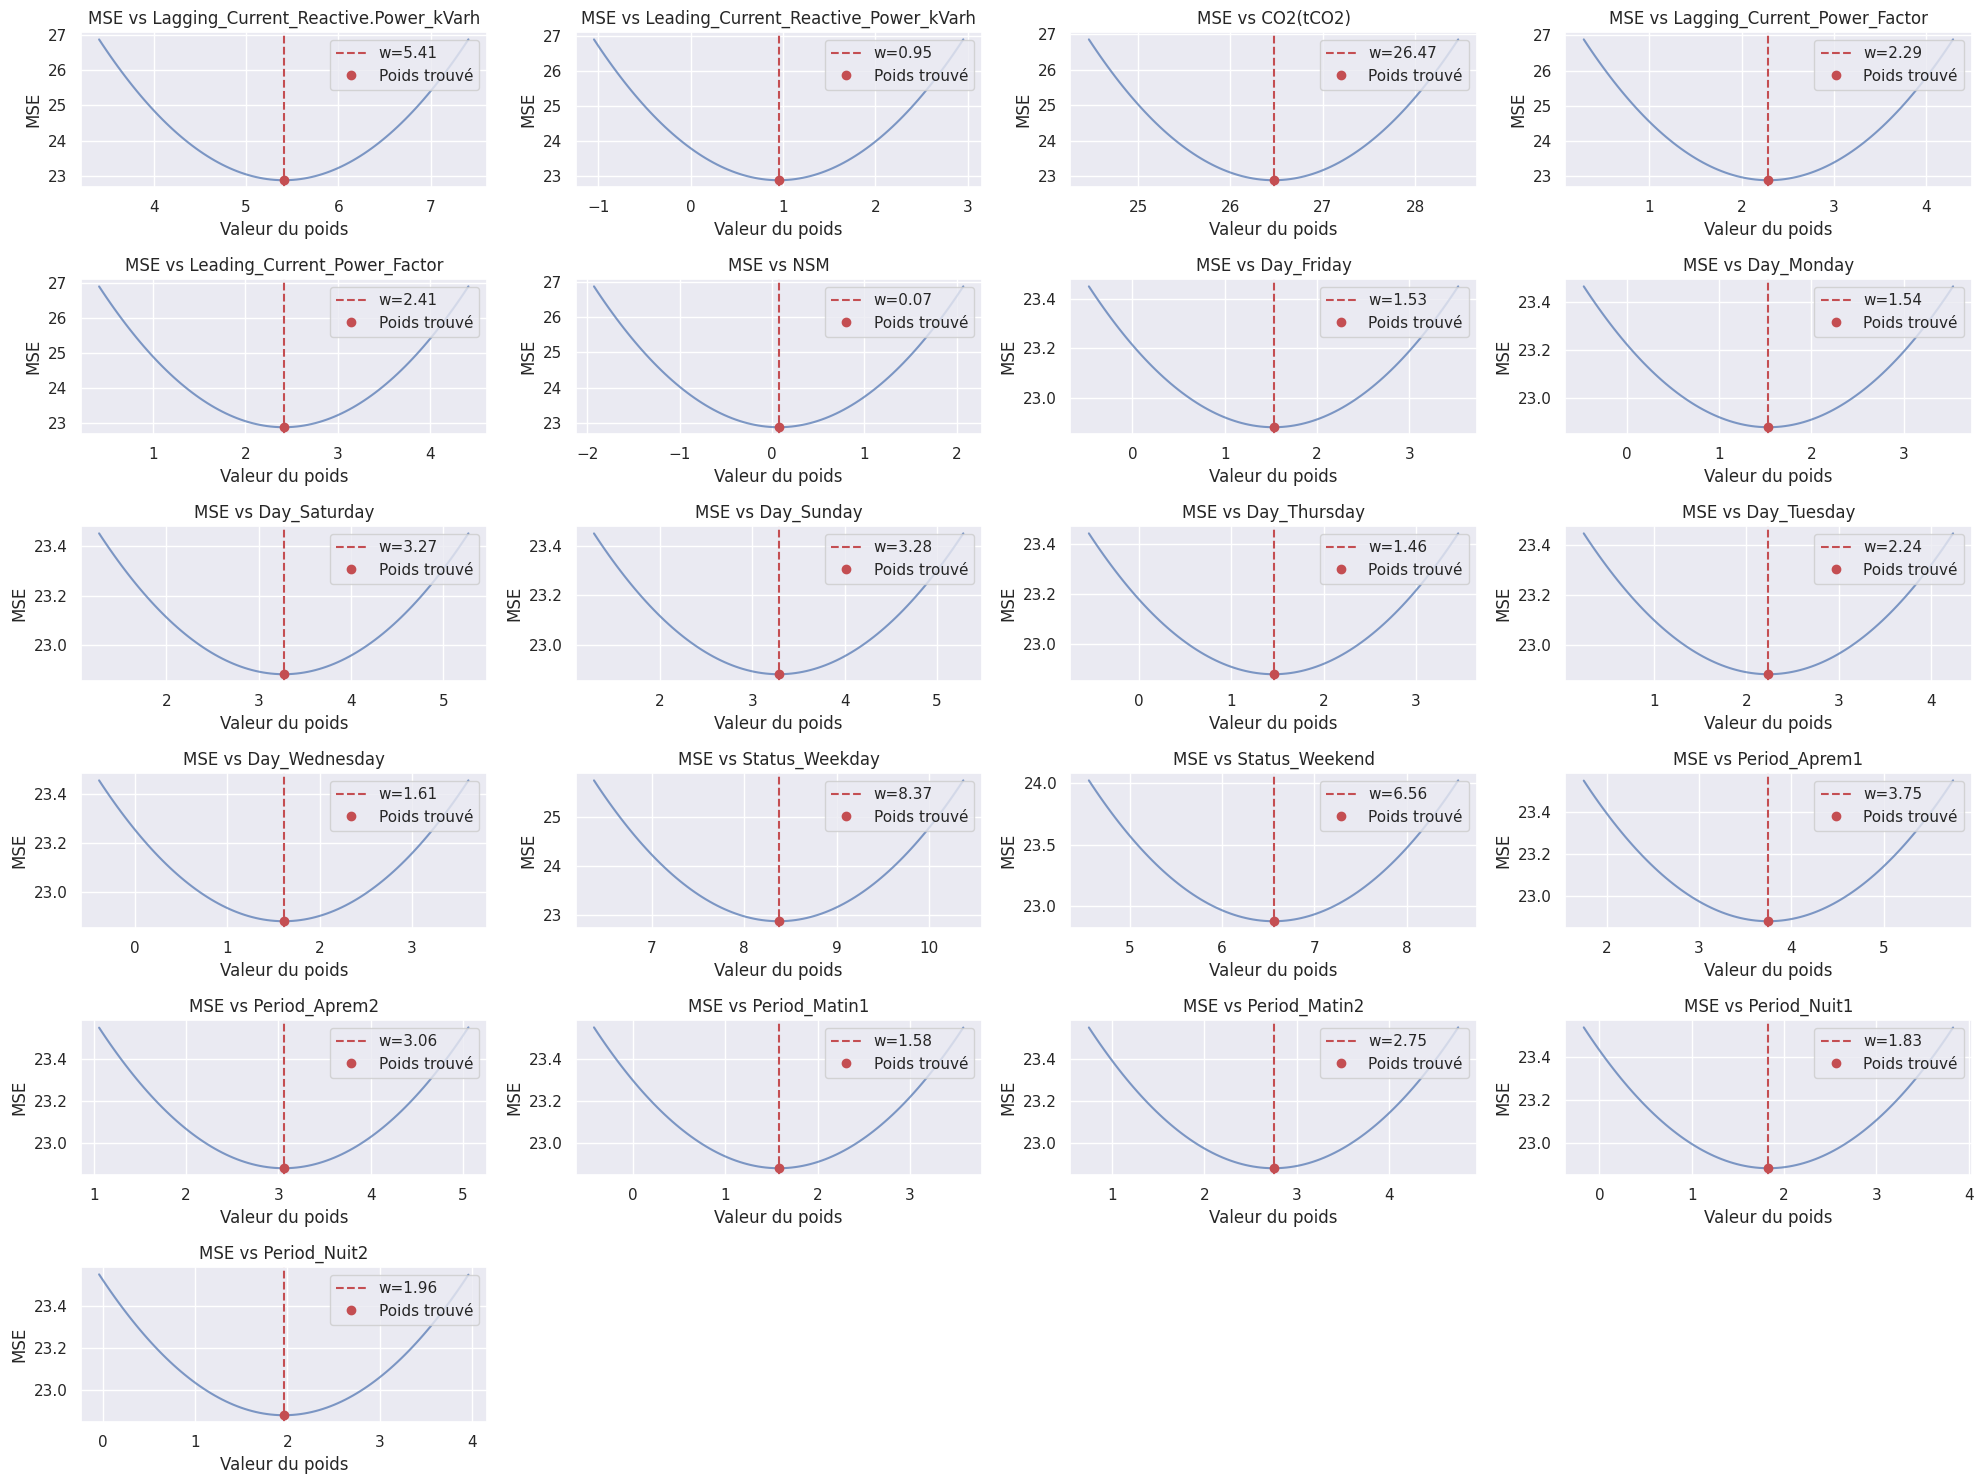

In [6]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.weights_history = []
        self.bias_history = []

    def fit(self, X, y):
        # Initialisation des paramètres
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Historique pour visualisation
        self.loss_history = []
        self.weights_history = []
        self.bias_history = []

        # Descente de gradient
        for i in range(self.n_iterations):
            # Prédiction courante
            y_pred = np.dot(X, self.weights) + self.bias

            # Calcul des gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Mise à jour des paramètres
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # Calcul et sauvegarde de la loss et des paramètres
            loss = np.mean((y_pred - y) ** 2)
            self.loss_history.append(loss)
            self.weights_history.append(self.weights.copy())
            self.bias_history.append(self.bias)

            # Affichage progression
            if (i+1) % 1000 == 0:
                print(f'Iteration {i+1}/{self.n_iterations}, Loss: {loss:.4f}')

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Visualisation de l'erreur en fonction de chaque poids
def plot_error_vs_weights(X, y, weights, bias, feature_names, n_points=100):
    plt.figure(figsize=(20, 15))
    n_features = len(weights)
    n_rows = (n_features + 3) // 4  # Arrondi supérieur pour le nombre de lignes

    for i, (feature_name, weight) in enumerate(zip(feature_names, weights)):
        # Créer une plage de valeurs autour du poids optimal
        weight_range = np.linspace(weight - 2, weight + 2, n_points)
        errors = []

        # Calculer l'erreur pour chaque valeur du poids
        for w in weight_range:
            weights_temp = weights.copy()
            weights_temp[i] = w
            y_pred = np.dot(X, weights_temp) + bias
            mse = np.mean((y - y_pred) ** 2)
            errors.append(mse)

        # Tracer la courbe d'erreur
        plt.subplot(n_rows, 4, i+1)
        plt.plot(weight_range, errors, 'b-', alpha=0.7)
        plt.axvline(x=weight, color='r', linestyle='--', label=f'w={weight:.2f}')
        plt.title(f'MSE vs {feature_name}')
        plt.xlabel('Valeur du poids')
        plt.ylabel('MSE')
        plt.grid(True)

        # Marquer le poids trouvé
        plt.plot(weight, np.min(errors), 'ro', label='Poids trouvé')
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Entraînement des deux modèles
lr_gd = LinearRegressionGD(learning_rate=0.01, n_iterations=15000)
# /!\ Complétez les '...' pour appliquer la régression linéaire lr_gd aux données /!\
lr_gd.fit(X_train.values, y_train.values)

lr_sk = LinearRegression()
# /!\ Complétez les '...' pour appliquer la régression linéaire lr_sk aux données /!\
lr_sk.fit(X_train, y_train)

# Comparaison des performances
print("\nComparaison des deux implémentations :")
comparison = pd.DataFrame(columns=['GD', 'Sklearn'])

# Prédictions
y_pred_gd = lr_gd.predict(X_test.values)
y_pred_sk = lr_sk.predict(X_test)

# Métriques
comparison.loc['R² score'] = [
    r2_score(y_test, y_pred_gd),
    r2_score(y_test, y_pred_sk)
]
comparison.loc['MSE'] = [
    mean_squared_error(y_test, y_pred_gd),
    mean_squared_error(y_test, y_pred_sk)
]
comparison.loc['RMSE'] = [
    np.sqrt(mean_squared_error(y_test, y_pred_gd)),
    np.sqrt(mean_squared_error(y_test, y_pred_sk))
]

print("\nMétriques de performance :")
display(comparison.round(4))

# Comparaison des coefficients
coef_comparison = pd.DataFrame({
    'Feature': X_train.columns,
    'GD': lr_gd.weights,
    'Sklearn': lr_sk.coef_,
    'Différence': np.abs(lr_gd.weights - lr_sk.coef_)
})

print("\nComparaison des coefficients :")
display(coef_comparison.round(4))

# Affichage de l'équation complète (avec les 5 coefficients les plus importants)
print("\nÉquation de régression :")
print(f"Usage_kWh = {lr_gd.bias:.2f}", end=" ")
top_coefs = coef_comparison.assign(abs_coef=lambda x: np.abs(x['GD'])).nlargest(21, 'abs_coef')
for _, row in top_coefs.iterrows():
    print(f"+ ({row['GD']:.2f} × {row['Feature']})", end=" ")
print("\n")

# Visualisation des courbes d'erreur
plot_error_vs_weights(X_train.values, y_train.values,
                     lr_gd.weights, lr_gd.bias,
                     feature_names=X_train.columns)

### Interprétation des métriques :

1. **R² (Coefficient de détermination)**
   - Varie entre 0 et 1 (ou négatif si le modèle est très mauvais)
   - Plus il est proche de 1, meilleur est le modèle
   - Représente la proportion de variance expliquée par le modèle
   - Un R² de 0.8 signifie que le modèle explique 80% de la variabilité des données

2. **MSE (Mean Squared Error)**
   - Moyenne des erreurs au carré
   - Pénalise fortement les grandes erreurs
   - Difficile à interpréter car unité au carré

3. **RMSE (Root Mean Squared Error)**
   - Racine carrée du MSE
   - Même unité que la variable cible (kWh)
   - Plus facile à interpréter : erreur moyenne en kWh
   - Exemple : RMSE = 10 signifie une erreur moyenne de ±10 kWh

❓ **Questions approfondies sur la régression linéaire :**

1. **Convergence**
   - Comment évolue la loss au fil des itérations ?
   - Pourquoi la diminution est-elle rapide au début puis plus lente ?
   - Comment savoir si on a atteint le minimum global ?

2. **Comparaison avec sklearn**
   - Les coefficients sont-ils similaires ?
   - Pourquoi y a-t-il des différences ?

3. **Compréhension mathématique**
   - Pourquoi utilise-t-on la MSE (Mean Squared Error) comme fonction de perte ?

4. **Analyse des coefficients**
   - Pourquoi CO2(tCO2) a-t-il le plus grand coefficient (26.47) ?
   - Les coefficients négatifs signifient-ils une influence négative ?

5. **Courbes d'erreur**
   - Pourquoi les courbes ont-elles une forme parabolique ?
   - Que signifie la largeur de la parabole pour chaque feature ?
   - Pourquoi certaines features ont-elles un impact plus important ?

### 3. K plus proches voisins (KNN)
L'algorithme des K plus proches voisins est une méthode non-paramétrique qui prédit la consommation
en se basant sur les k observations les plus similaires.

Mémorisation de 28032 observations d'entraînement

Test avec k=1:

Détails de la prédiction:
Observation à prédire: [-0.59643827 -0.52138505 -0.71355023 -0.36827002  0.51326762  1.67801526
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.        ]

Plus proches voisins trouvés:
Voisin 1:
- Distance: 0.04
- Valeur: 3.71

Prédiction finale: 3.71

Métriques globales:
R² score: 0.992
MSE: 9.137
RMSE: 3.023
Mémorisation de 28032 observations d'entraînement

Test avec k=2:

Détails de la prédiction:
Observation à prédire: [-0.59643827 -0.52138505 -0.71355023 -0.36827002  0.51326762  1.67801526
  0.          0.          0.          0.          0.          1.
  0.          1.          0.          0.          0.          0.
  0.          1.          0.        ]

Plus proches voisins trouvés:
Voisin 1:
- Distance: 0.04
- Valeur: 3.71
Voisin 2:
- Distance: 0.04
- Valeur: 3.85

Prédiction f

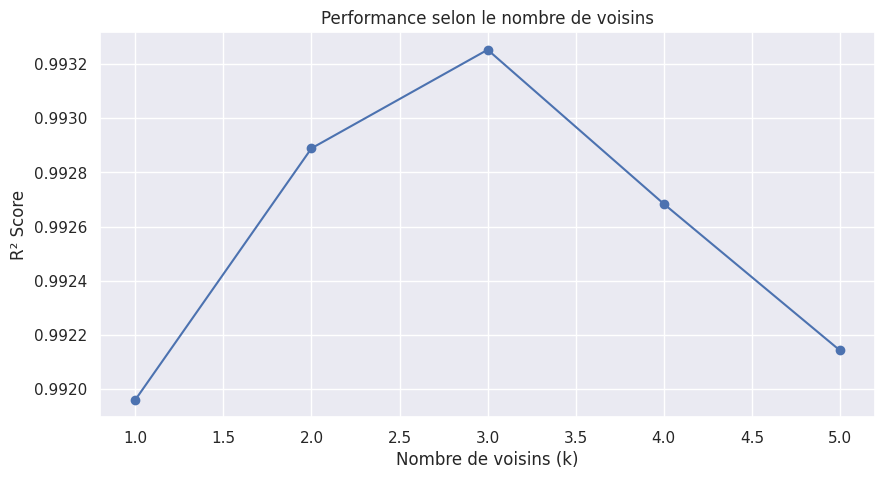

In [7]:
class SimpleKNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """Mémorise simplement les données d'entraînement"""
        self.X_train = X
        self.y_train = y
        print(f"Mémorisation de {len(X)} observations d'entraînement")

    def predict_single(self, x, verbose=False):
        """Prédit pour une seule observation avec option d'affichage des détails"""
        # Calcul des distances avec tous les points d'entraînement
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))

        # Trouve les k plus proches voisins
        nearest_indices = np.argsort(distances)[:self.k]
        nearest_distances = distances[nearest_indices]

        if verbose:
            print("\nDétails de la prédiction:")
            print(f"Observation à prédire: {x}")
            print("\nPlus proches voisins trouvés:")
            for i, (idx, dist) in enumerate(zip(nearest_indices, nearest_distances)):
                print(f"Voisin {i+1}:")
                print(f"- Distance: {dist:.2f}")
                print(f"- Valeur: {self.y_train[idx]:.2f}")

        # Calcul de la prédiction (moyenne simple)
        prediction = np.mean(self.y_train[nearest_indices])

        if verbose:
            print(f"\nPrédiction finale: {prediction:.2f}")

        return prediction

    def predict(self, X):
        """Prédit pour plusieurs observations"""
        return np.array([self.predict_single(x) for x in X])

# Test avec différentes valeurs de k
k_values = [1, 2, 3, 4, 5]
knn_scores = []

# Création d'un exemple simple pour visualisation
example_idx = 42  # Un indice arbitraire pour l'exemple

for k in k_values:
    knn = SimpleKNN(k=k)
    knn.fit(X_train.values, y_train.values)

    # Prédiction détaillée pour l'exemple
    print(f"\nTest avec k={k}:")
    example_pred = knn.predict_single(X_test.values[example_idx], verbose=True)

    # Calcul des métriques
    y_pred = knn.predict(X_test.values)
    # /!\ Complétez les '...' pour calculer le R² entre la valeur cible réel et la prédiction /!\
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    knn_scores.append(r2)

    print(f"\nMétriques globales:")
    print(f"R² score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")

# Visualisation de l'impact de k
plt.figure(figsize=(10, 5))
plt.plot(k_values, knn_scores, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('R² Score')
plt.title('Performance selon le nombre de voisins')
plt.grid(True)
plt.show()

❓ **Questions sur l'algorithme KNN :**

1. **Compréhension de l'algorithme**
   - Comment le KNN fait-il ses prédictions pour une nouvelle observation ?
   - Pourquoi est-il important que les variables soient standardisées ?

2. **Choix de k**
   - Que se passe-t-il si k est trop petit (k=1) ?
   - Que se passe-t-il si k est trop grand (k proche de n) ?
   - Pourquoi observe-t-on un k optimal dans la courbe de performance ?

3. **Interprétabilité**
   - Comment expliquer une prédiction KNN à un utilisateur ?
   - Peut-on identifier les variables les plus importantes ?

### 4. Arbres de décision
Les arbres de décision permettent de créer des règles de prédiction facilement interprétables.
Ils peuvent capturer des relations non linéaires et sont particulièrement utiles dans un contexte industriel.

Points clés :
- Modèle transparent et interprétable
- Capable de capturer des relations non linéaires
- Risque de surapprentissage à contrôler

L'arbre de décision divise récursivement les données en sous-groupes homogènes
en choisissant les meilleures variables et seuils de séparation.

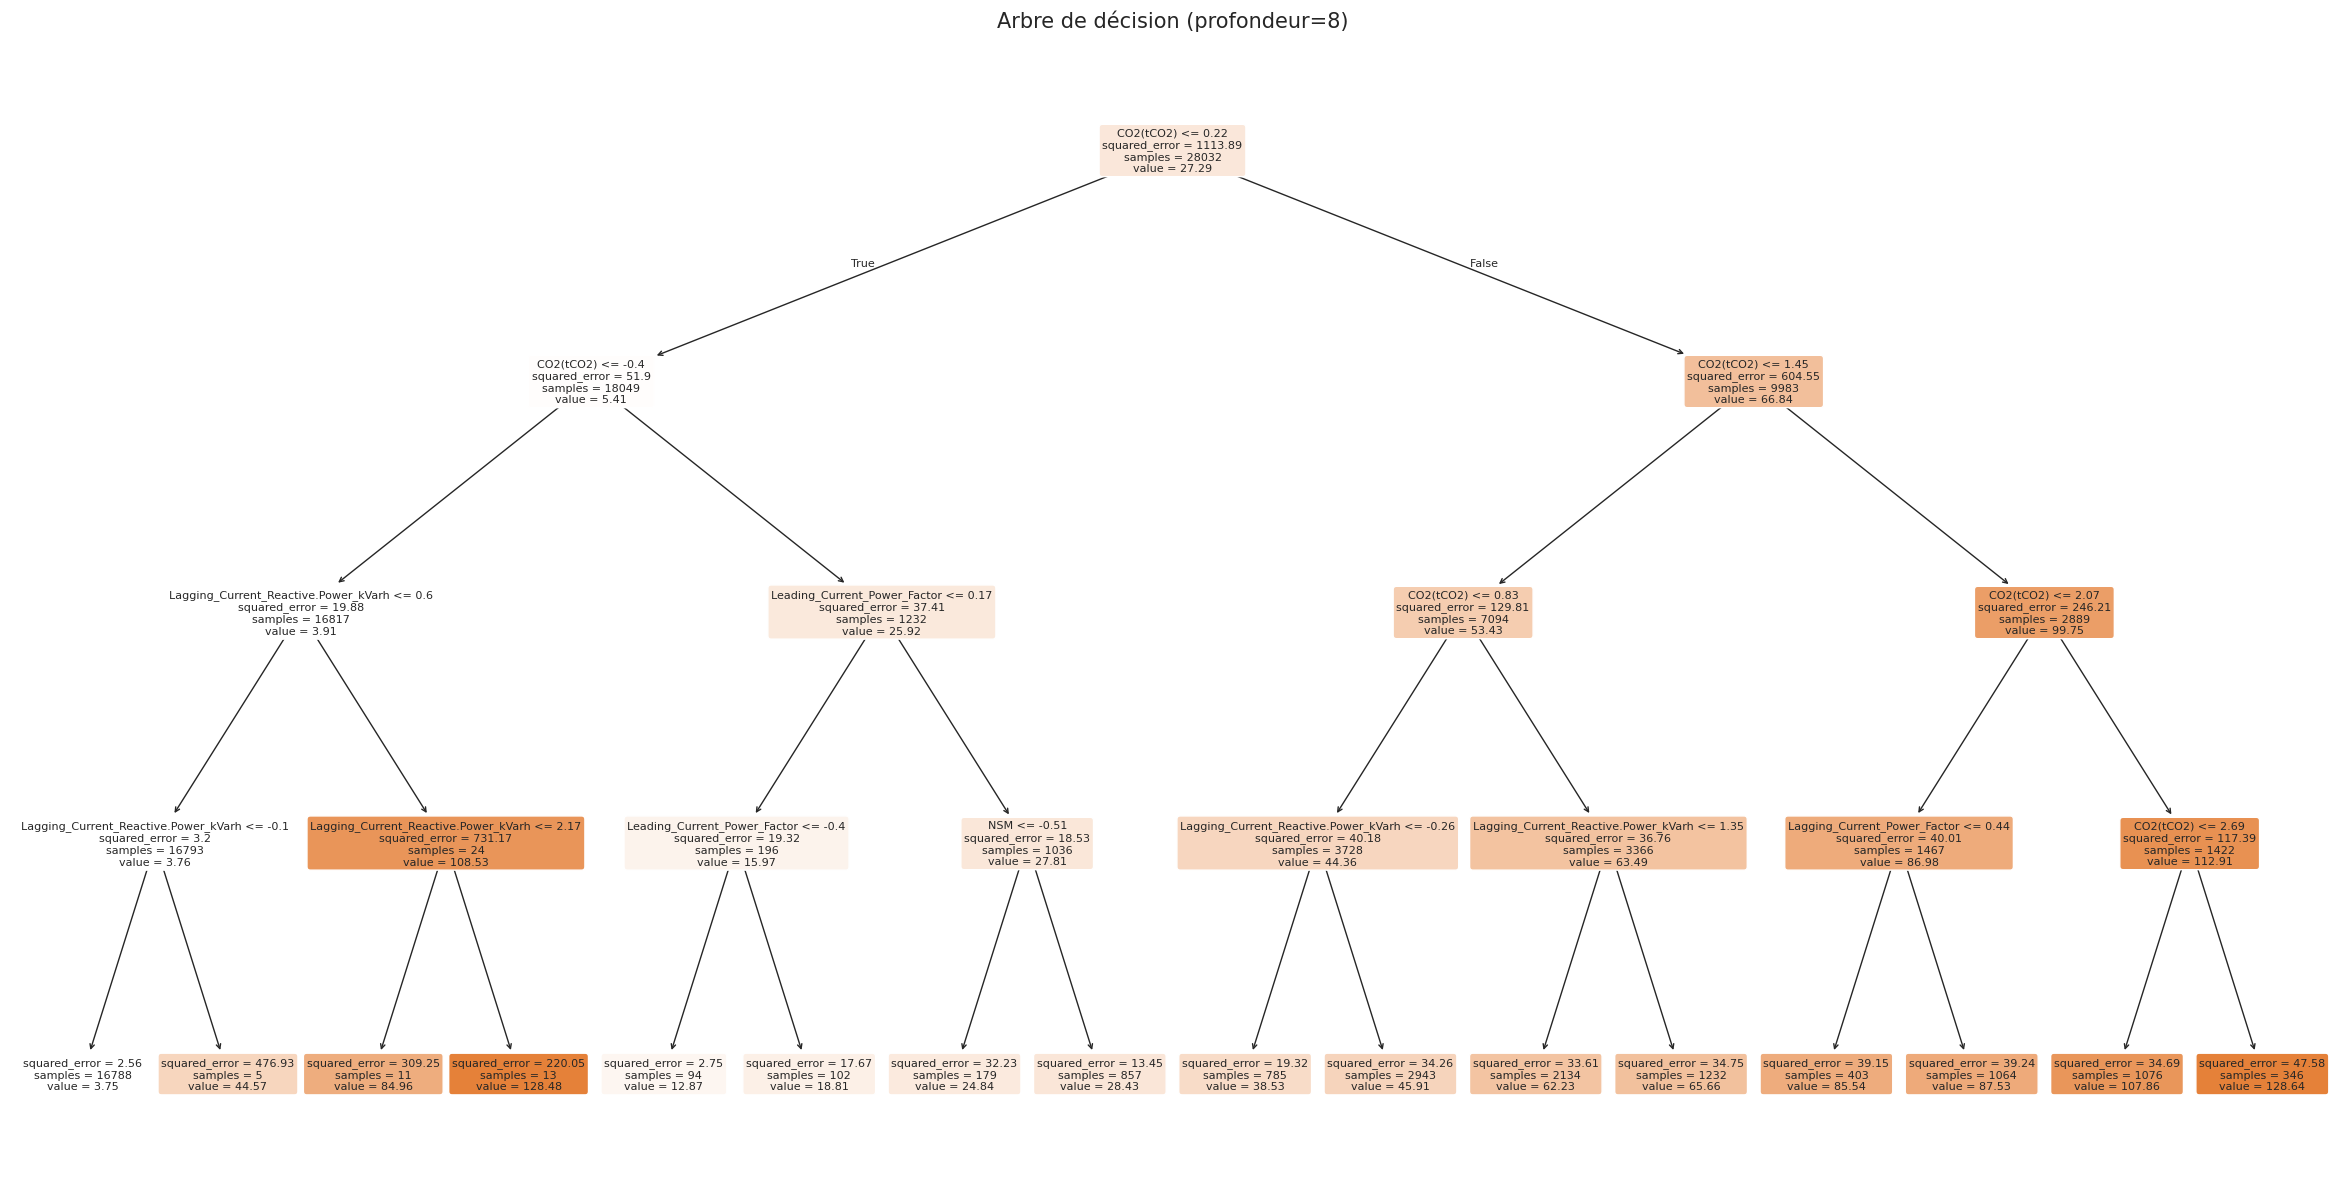


Détails de l'instance à prédire:

Valeur réelle de consommation: 3.60 kWh
Valeur prédite: 3.75 kWh

Caractéristiques non nulles de l'instance:
Lagging_Current_Reactive.Power_kVarh: -0.60
Leading_Current_Reactive_Power_kVarh: -0.52
CO2(tCO2): -0.71
Lagging_Current_Power_Factor: -0.37
Leading_Current_Power_Factor: 0.51
NSM: 1.68
Day_Tuesday: 1.00
Status_Weekday: 1.00
Period_Nuit1: 1.00

Chemin de décision détaillé:

Niveau 1:
   Test: CO2(tCO2) ≤ 0.22
   Valeur mesurée: -0.71
   Nombre d'observations: 28032
   Moyenne du groupe: 27.29 kWh
   → Branche gauche (condition vraie)

Niveau 2:
   Test: CO2(tCO2) ≤ -0.40
   Valeur mesurée: -0.71
   Nombre d'observations: 18049
   Moyenne du groupe: 5.41 kWh
   → Branche gauche (condition vraie)

Niveau 3:
   Test: Lagging_Current_Reactive.Power_kVarh ≤ 0.60
   Valeur mesurée: -0.60
   Nombre d'observations: 16817
   Moyenne du groupe: 3.91 kWh
   → Branche gauche (condition vraie)

Niveau 4:
   Test: Lagging_Current_Reactive.Power_kVarh ≤ -0.1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [8]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Création et entraînement de l'arbre avec profondeur 4
dt = DecisionTreeRegressor(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

# Visualisation de l'arbre avec une meilleure lisibilité
plt.figure(figsize=(30, 15))  # Grande taille pour la lisibilité
plot_tree(dt,
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=8,  # Taille de la police
          precision=2)  # Nombre de décimales pour les valeurs
plt.title('Arbre de décision (profondeur=8)', fontsize=15)
plt.show()

# Exemple de prédiction détaillée
example_idx = 42
example = X_test.iloc[example_idx]
real_value = y_test.iloc[example_idx]
prediction = dt.predict([example])[0]

print("\nDétails de l'instance à prédire:")
print(f"\nValeur réelle de consommation: {real_value:.2f} kWh")
print(f"Valeur prédite: {prediction:.2f} kWh")

print("\nCaractéristiques non nulles de l'instance:")
for feature, value in example.items():
    if abs(value) > 0.01:  # On n'affiche que les valeurs non nulles
        print(f"{feature}: {value:.2f}")

print("\nChemin de décision détaillé:")

print("\nNiveau 1:")
print("   Test: CO2(tCO2) ≤ 0.22")
print("   Valeur mesurée: -0.71")
print("   Nombre d'observations: 28032")
print("   Moyenne du groupe: 27.29 kWh")
print("   → Branche gauche (condition vraie)")

print("\nNiveau 2:")
print("   Test: CO2(tCO2) ≤ -0.40")
print("   Valeur mesurée: -0.71")
print("   Nombre d'observations: 18049")
print("   Moyenne du groupe: 5.41 kWh")
print("   → Branche gauche (condition vraie)")

print("\nNiveau 3:")
print("   Test: Lagging_Current_Reactive.Power_kVarh ≤ 0.60")
print("   Valeur mesurée: -0.60")
print("   Nombre d'observations: 16817")
print("   Moyenne du groupe: 3.91 kWh")
print("   → Branche gauche (condition vraie)")

print("\nNiveau 4:")
print("   Test: Lagging_Current_Reactive.Power_kVarh ≤ -0.1")
print("   Valeur mesurée: -0.60")
print("   Nombre d'observations: 16793")
print("   Moyenne du groupe: 3.76 kWh")
print("   → Branche gauche (condition vraie)")

print("\n→ Feuille finale:")
print("   - Nombre d'observations: 16788")
print("   - Valeur prédite: 3.75 kWh")

# Métriques de performance
y_pred = dt.predict(X_test)
print("\nMétriques de performance:")
print(f"R² score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.1f}")


# Création et entraînement de l'arbre avec profondeur 10
# /!\ Complétez les '...' pour entrainer un arbre de décision d'une profondeur de 10 /!\
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)


# Métriques de performance
y_pred = dt.predict(X_test)
print("\nMétriques de performance pour profondeur 10:")
print(f"R² score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.1f}")

❓ **Questions :**
1. Quelles sont les variables les plus importantes selon l'arbre de décision ?

2. Comment la profondeur de l'arbre influence-t-elle les performances ?

3. [FACULTATIF] **Structure de l'arbre**
   - Pourquoi CO2(tCO2) est-il souvent choisi comme première division ?
   - Comment le nombre d'observations diminue-t-il à chaque niveau ?
   - Quelle est la signification des valeurs moyennes dans les nœuds ?

4. [FACULTATIF] **Processus de prédiction**
   - Comment l'arbre arrive-t-il à sa prédiction finale ?
   - Pourquoi les prédictions sont-elles plus précises avec la profondeur ?

### 5. Random Forest
Le Random Forest est un ensemble d'arbres de décision qui permet d'améliorer la généralisation
et la stabilité des prédictions par rapport à un arbre unique.

Points clés :
- Meilleure généralisation que l'arbre simple
- Estimation robuste de l'importance des variables
- Réduction du surapprentissage

In [9]:
# Création d'un Random Forest simple avec 500 arbres pour la visualisation
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Exemple de prédiction détaillée
example_idx = 42
example = X_test.iloc[example_idx]
real_value = y_test.iloc[example_idx]

print("\nDétails de l'instance à prédire:")
print(f"Valeur réelle de consommation: {real_value:.2f} kWh")

print("\nCaractéristiques importantes de l'instance:")
for feature, value in example.items():
    if abs(value) > 0.01:  # On n'affiche que les valeurs non nulles
        print(f"{feature}: {value:.2f}")

# Prédiction de chaque arbre
print("\nPrédictions des arbres individuels:")
predictions = []
for i, tree in enumerate(rf.estimators_):
    pred = tree.predict([example])[0]
    predictions.append(pred)
    # print(f"\nArbre {i+1}:")
    # print(f"Prédiction: {pred:.2f} kWh")

    # Affichage du chemin de décision pour cet arbre
    path = tree.decision_path([example])
    feature_path = []
    for node_id in path.indices:
        if node_id == tree.tree_.children_left[path.indices[0]]:  # Si c'est une feuille
            continue
        feature = X_train.columns[tree.tree_.feature[node_id]]
        threshold = tree.tree_.threshold[node_id]
        value = example[feature]
        direction = "gauche" if value <= threshold else "droite"
        feature_path.append(f"   {feature} ≤ {threshold:.2f} ? {value:.2f} → {direction}")

    # print("Chemin de décision:")
    # for step in feature_path:
    #     print(step)

# Prédiction finale (moyenne des arbres)
# /!\ Complétez les '...' pour obtenir la moyenne des predictions (Numpy) /!\
final_prediction = np.mean(predictions)
print(f"\nPrédiction finale (moyenne des arbres): {final_prediction:.2f} kWh")

# Métriques de performance
y_pred = rf.predict(X_test)
print("\nMétriques de performance:")
print(f"R² score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.1f}")

# Importance des variables
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 5 variables les plus importantes:")
print(importance.head().to_string())


Détails de l'instance à prédire:
Valeur réelle de consommation: 3.60 kWh

Caractéristiques importantes de l'instance:
Lagging_Current_Reactive.Power_kVarh: -0.60
Leading_Current_Reactive_Power_kVarh: -0.52
CO2(tCO2): -0.71
Lagging_Current_Power_Factor: -0.37
Leading_Current_Power_Factor: 0.51
NSM: 1.68
Day_Tuesday: 1.00
Status_Weekday: 1.00
Period_Nuit1: 1.00

Prédictions des arbres individuels:

Prédiction finale (moyenne des arbres): 3.73 kWh

Métriques de performance:
R² score: 0.997
RMSE: 1.9

Top 5 variables les plus importantes:
                                Feature  Importance
2                             CO2(tCO2)    0.978560
0  Lagging_Current_Reactive.Power_kVarh    0.014591
3          Lagging_Current_Power_Factor    0.004208
4          Leading_Current_Power_Factor    0.001201
5                                   NSM    0.000852


❓ **Questions :**
1. Pourquoi le Random Forest performe-t-il mieux que l'arbre simple ?

2. [FACULTATIF] Comparez l'importance des variables entre Random Forest et arbre simple.
   Laquelle des deux estimations vous semble plus fiable ? Pourquoi ?

3. [FACULTATIF] **Mécanisme de vote**
   - Pourquoi prendre la moyenne des prédictions des arbres ?

4. **Avantages par rapport à l'arbre simple**
   - Comment le Random Forest évite-t-il le surapprentissage ?
   - Pourquoi les prédictions sont-elles plus stables ?

### 6. Réseaux de neurones (MLP)
Le Multi-Layer Perceptron est un réseau de neurones capable de capturer des relations complexes
entre les variables. Il est particulièrement efficace pour les problèmes non-linéaires.

Points clés :
- Grande capacité d'apprentissage
- Capable de capturer des relations complexes
- Nécessite un réglage fin des hyperparamètres

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Détails de l'instance à prédire:
Valeur réelle de consommation: 3.60 kWh
Valeur prédite: 3.77 kWh

Caractéristiques importantes de l'instance:
Lagging_Current_Reactive.Power_kVarh: -0.60
Leading_Current_Reactive_Power_kVarh: -0.52
CO2(tCO2): -0.71
Lagging_Current_Power_Factor: -0.37
Leading_Current_Power_Factor: 0.51
NSM: 1.68
Day_Tuesday: 1.00
Status_Weekday: 1.00
Period_Nuit1: 1.00

Comparaison des architectures:


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (12,):
- Nombre de neurones par couche: Entrée(21) → 12 → Sortie(1)
- Nombre total de paramètres: 3,540
- Prédiction pour l'exemple: 3.60 kWh
- R² score global: 0.998


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (25,):
- Nombre de neurones par couche: Entrée(21) → 25 → Sortie(1)
- Nombre total de paramètres: 14,200
- Prédiction pour l'exemple: 3.62 kWh
- R² score global: 0.999


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (12, 6):
- Nombre de neurones par couche: Entrée(21) → 12 → 6 → Sortie(1)
- Nombre total de paramètres: 19,158
- Prédiction pour l'exemple: 3.77 kWh
- R² score global: 0.998


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (25, 12):
- Nombre de neurones par couche: Entrée(21) → 25 → 12 → Sortie(1)
- Nombre total de paramètres: 162,462
- Prédiction pour l'exemple: 3.34 kWh
- R² score global: 0.999


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(



Architecture (25, 12, 6):
- Nombre de neurones par couche: Entrée(21) → 25 → 12 → 6 → Sortie(1)
- Nombre total de paramètres: 180,960
- Prédiction pour l'exemple: 3.94 kWh
- R² score global: 0.999


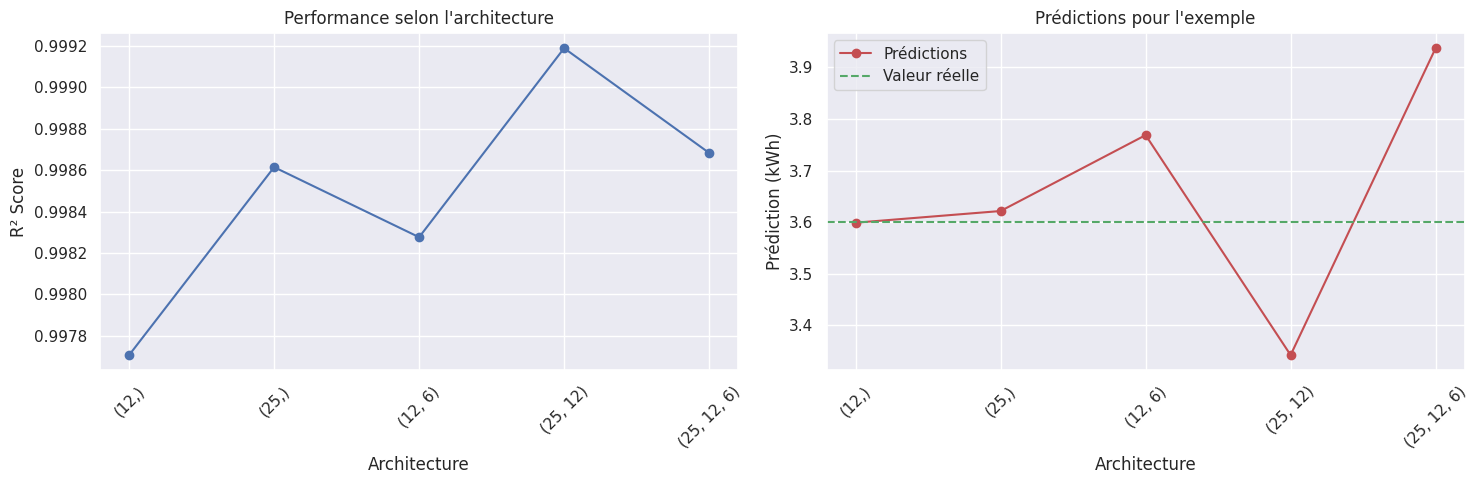

In [11]:
# Création d'un MLP simple pour la visualisation
mlp = MLPRegressor(hidden_layer_sizes=(12, 6),
                  max_iter=250,
                  activation='relu',
                  solver='adam',
                  random_state=42)
# /!\ Complétez les '...' pour que le réseau de neurone apprenne à prédire y_train grâce aux X_train/!\
mlp.fit(X_train, y_train)

# Exemple de prédiction détaillée
example_idx = 42
example = X_test.iloc[example_idx]
real_value = y_test.iloc[example_idx]
prediction = mlp.predict([example])[0]

print("\nDétails de l'instance à prédire:")
print(f"Valeur réelle de consommation: {real_value:.2f} kWh")
print(f"Valeur prédite: {prediction:.2f} kWh")

print("\nCaractéristiques importantes de l'instance:")
for feature, value in example.items():
    if abs(value) > 0.01:  # On n'affiche que les valeurs non nulles
        print(f"{feature}: {value:.2f}")

# Test de différentes architectures
architectures = [(12,), (25,), (12, 6), (25, 12), (25, 12, 6)]
mlp_scores = []
mlp_predictions = []

print("\nComparaison des architectures:")
for arch in architectures:
    # Création et entraînement du modèle
    mlp = MLPRegressor(hidden_layer_sizes=arch,
                      max_iter=250,
                      random_state=42)
    mlp.fit(X_train, y_train)

    # Calcul du nombre de paramètres
    n_params = sum(layer.size * next_layer.size + next_layer.size
                  for layer, next_layer in zip([np.array([X_train.shape[1]])] + mlp.coefs_[:-1],
                                             mlp.coefs_))

    # Prédiction pour l'exemple
    pred = mlp.predict([example])[0]
    mlp_predictions.append(pred)

    # Score global
    score = r2_score(y_test, mlp.predict(X_test))
    mlp_scores.append(score)

    print(f"\nArchitecture {arch}:")
    print(f"- Nombre de neurones par couche: Entrée({X_train.shape[1]}) → {' → '.join(str(x) for x in arch)} → Sortie(1)")
    print(f"- Nombre total de paramètres: {n_params:,}")
    print(f"- Prédiction pour l'exemple: {pred:.2f} kWh")
    print(f"- R² score global: {score:.3f}")

# Visualisation des résultats
plt.figure(figsize=(15, 5))

# Scores R²
plt.subplot(1, 2, 1)
plt.plot(range(len(architectures)), mlp_scores, 'bo-')
plt.xticks(range(len(architectures)), [str(arch) for arch in architectures], rotation=45)
plt.xlabel('Architecture')
plt.ylabel('R² Score')
plt.title('Performance selon l\'architecture')
plt.grid(True)

# Prédictions pour l'exemple
plt.subplot(1, 2, 2)
plt.plot(range(len(architectures)), mlp_predictions, 'ro-', label='Prédictions')
plt.axhline(y=real_value, color='g', linestyle='--', label='Valeur réelle')
plt.xticks(range(len(architectures)), [str(arch) for arch in architectures], rotation=45)
plt.xlabel('Architecture')
plt.ylabel('Prédiction (kWh)')
plt.title('Prédictions pour l\'exemple')
plt.legend()

plt.tight_layout()
plt.show()

❓ **Questions sur le MLP:**

1. **Architecture du réseau**
   - Pourquoi utiliser plusieurs couches cachées ?
   - Comment choisir le nombre de neurones par couche ?

2. **Comparaison des architectures**
   - Quelle architecture donne les meilleurs résultats ? Pourquoi ?
   - [FACULTATIF] Y a-t-il un compromis entre complexité et performance ?

### 7. Comparaison finale des modèles

Comparons maintenant tous les modèles pour choisir le plus adapté à notre problème.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warni


Prédictions pour l'exemple (consommation réelle: 3.60 kWh):
Régression linéaire: 5.28 kWh
KNN: 4.04 kWh
Arbre de décision: 3.75 kWh
Random Forest: 3.73 kWh
MLP: 3.34 kWh

Métriques globales:
                Modèle     R²     MSE   RMSE
0  Régression linéaire  0.984  17.888  4.229
1                  KNN  0.993   7.670  2.769
2    Arbre de décision  0.995   5.399  2.324
3        Random Forest  0.997   3.638  1.907
4                  MLP  0.999   0.921  0.960


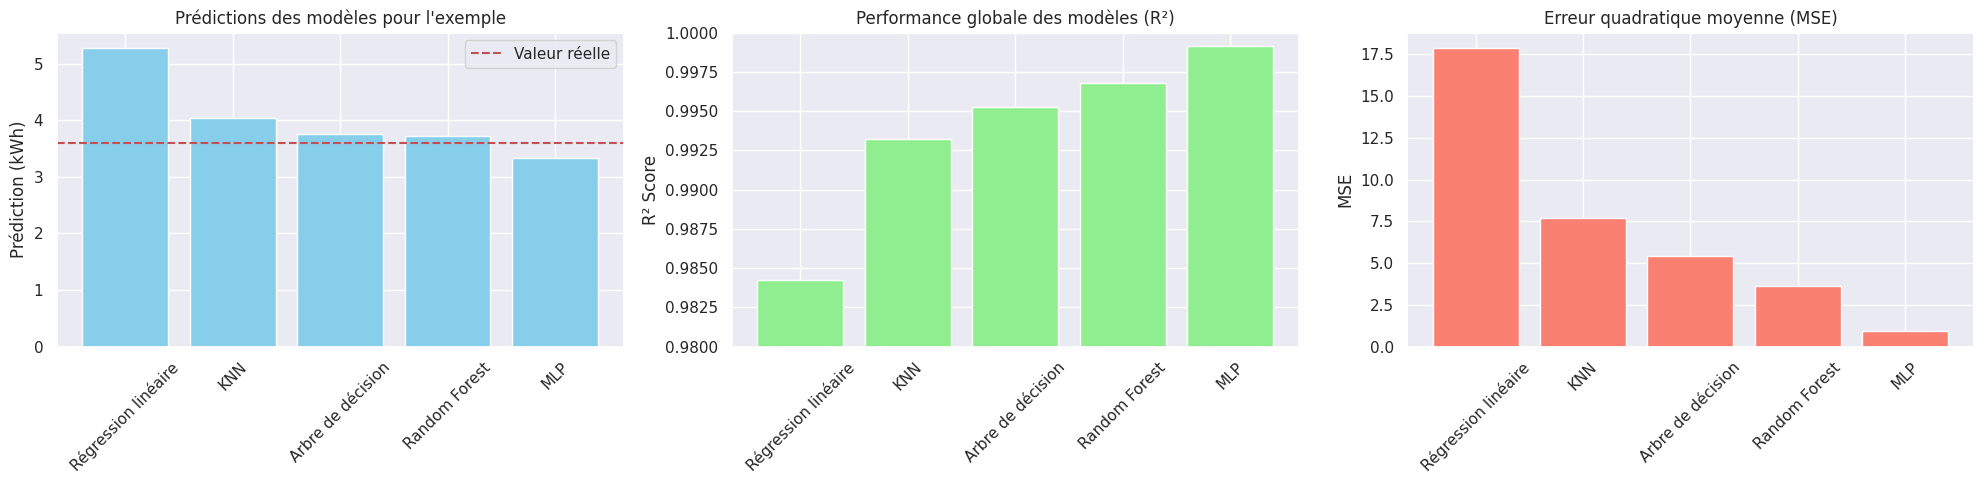

In [12]:
# Création et entraînement des meilleurs modèles
# 1. Régression linéaire (déjà créée)
lr_sk = LinearRegression()
lr_sk.fit(X_train, y_train)

# 2. KNN (avec le meilleur k trouvé)
knn_best = KNeighborsRegressor(n_neighbors=3)  # k=3 donnait les meilleurs résultats
knn_best.fit(X_train, y_train)

# 3. Arbre de décision (déjà créé)
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)

# 4. Random Forest (déjà créé)
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# 5. MLP (déjà créé)
mlp = MLPRegressor(hidden_layer_sizes=(25, 12), max_iter=250, random_state=42)
mlp.fit(X_train, y_train)


example_idx = 42
example = X_test.iloc[example_idx]
real_value = y_test.iloc[example_idx]

# Dictionnaire des modèles
models = {
    'Régression linéaire': lr_sk,
    'KNN': knn_best,
    'Arbre de décision': dt,
    'Random Forest': rf,
    'MLP': mlp
}

# Comparaison détaillée
print("\nPrédictions pour l'exemple (consommation réelle: {:.2f} kWh):".format(real_value))
predictions = {}
for name, model in models.items():
    pred = model.predict([example])[0]
    predictions[name] = pred
    print(f"{name}: {pred:.2f} kWh")

# Calcul des métriques globales
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Modèle': name,
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# /!\ Complétez les '...' pour affecter à result_df un dataframe contenant les résultats results /!\
results_df = pd.DataFrame(results)
print("\nMétriques globales:")
print(results_df.round(3))

# Visualisation des comparaisons
plt.figure(figsize=(20, 5))

# 1. Prédictions sur l'exemple
plt.subplot(1, 3, 1)
plt.bar(predictions.keys(), predictions.values(), color='skyblue')
plt.axhline(y=real_value, color='r', linestyle='--', label='Valeur réelle')
plt.xticks(rotation=45)
plt.ylabel('Prédiction (kWh)')
plt.title('Prédictions des modèles pour l\'exemple')
plt.legend()

# 2. Scores R²
plt.subplot(1, 3, 2)
plt.bar(results_df['Modèle'], results_df['R²'], color='lightgreen')
plt.xticks(rotation=45)
plt.ylabel('R² Score')
plt.title('Performance globale des modèles (R²)')
# Ajuster l'échelle pour mieux voir les différences
plt.ylim(0.98, 1.0)  # Les scores R² sont tous > 0.98
plt.grid(True, axis='y')

# 3. MSE
plt.subplot(1, 3, 3)
plt.bar(results_df['Modèle'], results_df['MSE'], color='salmon')
plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.title('Erreur quadratique moyenne (MSE)')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

❓ **Analyse comparative des modèles:**

1. **Compromis Complexité/Interprétabilité**
   - Dans un contexte industriel, est-il préférable d'utiliser un modèle simple comme l'arbre de décision ou un modèle plus complexe comme le MLP ?
   - Comment justifier le choix du modèle ?
   - Quels sont les avantages et inconvénients d'utiliser un modèle "boîte noire" comme le MLP dans un environnement industriel ?

2. [FACULTATIF] **Aspects Pratiques et Opérationnels**
   - Comment gérer la mise à jour des modèles avec l'arrivée de nouvelles données ?

3. **Optimisation et Amélioration**
   - Comment utiliser ces prédictions pour optimiser la consommation énergétique ?
   - Quelles recommandations concrètes peut-on faire à cet industriel ?

4. **Robustesse et Maintenance**
   - Comment s'assurer que les modèles restent performants dans le temps ?
   - À quelle fréquence réentraîner les modèles ?